In [1]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from psis import *

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
df1 = pd.read_csv("../data/01-raw/test_scores.csv")
df2 = pd.read_csv("../data/02-processed/normalized_data.csv")
df = pd.merge(df2, df1[["SUBJID", "State"]], how='left', on="SUBJID")
df.dropna(inplace=True)
df

,SUBJID,SATMath,SATWriting,SATVerbal,GPA,state,gender,race,income,choice,accepted,school,numapply,habits,SAT,State
0,884230,-1.652536,-1.777725,-1.719744,-0.688423,AL,Female,Black,4.439333,4.0,1.0,2192.0,9,6,-1.918234,AL
1,884232,-1.845287,-1.681540,-1.324951,-2.113622,AL,Male,Black,4.243038,1.0,1.0,2192.0,6,6,-1.809764,AL
2,884233,-1.845287,-2.739570,-2.805425,-3.776353,AL,Male,Black,4.653213,4.0,0.0,2192.0,4,4,-2.749835,AL
3,884247,-0.592404,-0.623510,-0.239270,0.974309,AL,Female,Black,4.096910,1.0,1.0,2192.0,9,8,-0.544284,AL
4,884307,-0.977906,-0.334957,-0.930158,-0.688423,AL,Male,Black,4.096910,4.0,1.0,2192.0,9,7,-0.833536,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91259,886635,-3.098170,-1.008248,-2.015839,0.261710,FL,Female,Two or more race/ethnicity,5.397940,1.0,1.0,1691.0,6,5,-2.279800,FL
91260,886640,0.467728,0.530704,0.451618,0.261710,FL,Female,White,4.942008,1.0,1.0,1691.0,3,7,0.540414,FL
91261,886642,-0.110526,1.684918,1.339902,0.974309,FL,Female,Two or more race/ethnicity,4.829304,1.0,1.0,1691.0,9,6,1.082762,FL
91262,886648,-0.399653,-0.912064,-0.535365,-0.688423,FL,Male,White,4.829304,2.0,1.0,1691.0,6,7,-0.688910,FL


In [27]:
feature_cols = ["SAT", "GPA", "income"]
outcome_col = ["accepted"]

# Get dummy variables for school
df["school"] = df["school"].astype(np.int64)
dummy_school = pd.get_dummies(df["school"], prefix="school")
dummy_state = pd.get_dummies(df["State"], prefix="", prefix_sep="")
dummy_race = pd.get_dummies(df["race"], prefix="", prefix_sep="")
dummy_gender = pd.get_dummies(df["gender"], prefix="", prefix_sep="")
col_labels = feature_cols + list(dummy_school.columns) + list(dummy_state.columns) + list(dummy_race.columns) + list(dummy_gender.columns)
X = pd.concat([df[feature_cols], dummy_school, dummy_state, dummy_race, dummy_gender], axis=1).copy()

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X,
    df[outcome_col],
    train_size=10_000,
    test_size=1_000,
    random_state=17)

In [28]:
# Convert dataframes to np arrays
X_train = X_train_df.copy().to_numpy()
X_test  = X_test_df.copy().to_numpy()
y_train = y_train_df.copy().astype(np.int8).to_numpy().flatten()
y_test = y_test_df.copy().astype(np.int8).to_numpy().flatten()

In [29]:

model_code = """
data {
    int<lower=1> n;                     // number of data points
    int<lower=1> d;                     // explanatory variable dimension
    matrix[n, d] X;                     // explanatory variable
    array[n] int <lower=0,upper=1> y;   // response variable
    int<lower=1> p_alpha_df;            // prior alpha degrees of freedom
    real p_alpha_loc;                   // prior alpha location
    real p_alpha_scale;                 // prior scale alpha
    int<lower=1> p_beta_df;             // prior beta degrees of freedom
    int<lower=1> p_beta_global_df;      // prior beta global degrees of freedom
    real p_beta_global_scale;           // prior beta global scale
    int<lower=0> N_test;                // number of test samples
    matrix[N_test, d] X_test;           // test data
}

parameters {

    // intercept
    real alpha;

    // auxiliary variables for the variance parameters
    vector[d] z;
    vector[d] lambda_r1;
    vector<lower=0>[d] lambda_r2;
    real tau_r1;
    real<lower=0> tau_r2;
}

transformed parameters {

    vector[d] lambda;           // local variance parameter
    real tau;                   // global variance parameter
    vector[d] beta;             // explanatory variable weights
    vector[n] eta;              // linear predictor

    lambda = lambda_r1 .* sqrt(lambda_r2);
    tau = tau_r1 * sqrt(tau_r2);
    beta = z .* (lambda*tau);
    eta = alpha + X * beta;
}

model {

    // student t prior for intercept
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);

    z ~ normal(0.0, 1.0);

    // half t priors for lambdas
    lambda_r1 ~ normal(0.0, 1.0);
    lambda_r2 ~ inv_gamma(0.5*p_beta_df, 0.5*p_beta_df);

    // half t priors for tau
    tau_r1 ~ normal(0.0, p_beta_global_scale);
    tau_r2 ~ inv_gamma(0.5*p_beta_global_df, 0.5*p_beta_global_df);

    // observation model
    y ~ bernoulli_logit(eta);
}

generated quantities {
    // calculate the log likelihood
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);

    // generate values for Y tilde
    array[n] int<lower=0, upper=1> Y_tilde;
    Y_tilde = bernoulli_logit_rng(eta);

    // Make predictions
    vector[N_test] y_test;
    for (j in 1:N_test) {
        y_test[j] = bernoulli_logit_rng(alpha + X_test[j] * beta);
    }
}
"""

In [30]:
n = X_train.shape[0]
d = X_train.shape[1]
degf = d - 1
p0 = 200
tau0 = p0 / (d - p0) * (1/np.sqrt(n))
data_dict = dict(
    n=n,                # num data points
    d=d,                # num features
    X=X_train,                # data matrix  
    y=y_train,                # response variable
    p_alpha_df=degf,   # prior deg freedom for alpha
    p_alpha_loc=0,      # prior location for alpha
    p_alpha_scale=5,  # prior scale for alpha
    p_beta_df=degf,    # prior deg freedom for beta
    p_beta_global_df=degf,       # prior location for beta
    p_beta_global_scale=tau0,    # prior scale for beta
    N_test=X_test.shape[0],
    X_test=X_test
)

In [31]:
horseshoe_model = stan.build(model_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [32]:
fit = horseshoe_model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [33]:
az_fit = az.from_pystan(fit)

In [34]:
print(np.sum(az_fit.sample_stats["diverging"]))

<xarray.DataArray 'diverging' ()>
array(6)


In [35]:
summary_table = az.summary(az_fit, var_names=['alpha', 'beta'])
col_labels = feature_cols + list(dummy_school.columns) + list(dummy_state.columns) + list(dummy_race.columns) + list(dummy_gender.columns)
index_labels = ["intercept"] + col_labels
summary_table.index = index_labels
# print(summary_table.to_latex())
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.481,0.274,0.970,1.984,0.004,0.003,4176.0,2947.0,1.0
SAT,-0.320,0.029,-0.375,-0.266,0.000,0.000,4319.0,3472.0,1.0
GPA,0.097,0.027,0.046,0.148,0.000,0.000,4475.0,3141.0,1.0
income,-0.123,0.056,-0.225,-0.017,0.001,0.001,4897.0,3114.0,1.0
school_2,-0.014,0.060,-0.143,0.098,0.001,0.001,2151.0,2522.0,1.0
...,...,...,...,...,...,...,...,...,...
Other,-0.009,0.061,-0.127,0.122,0.002,0.001,1617.0,2149.0,1.0
Two or more race/ethnicity,0.040,0.064,-0.062,0.171,0.001,0.001,3053.0,2805.0,1.0
White,0.355,0.071,0.228,0.494,0.001,0.001,4779.0,3740.0,1.0
Female,0.061,0.067,-0.042,0.196,0.001,0.001,3265.0,3211.0,1.0


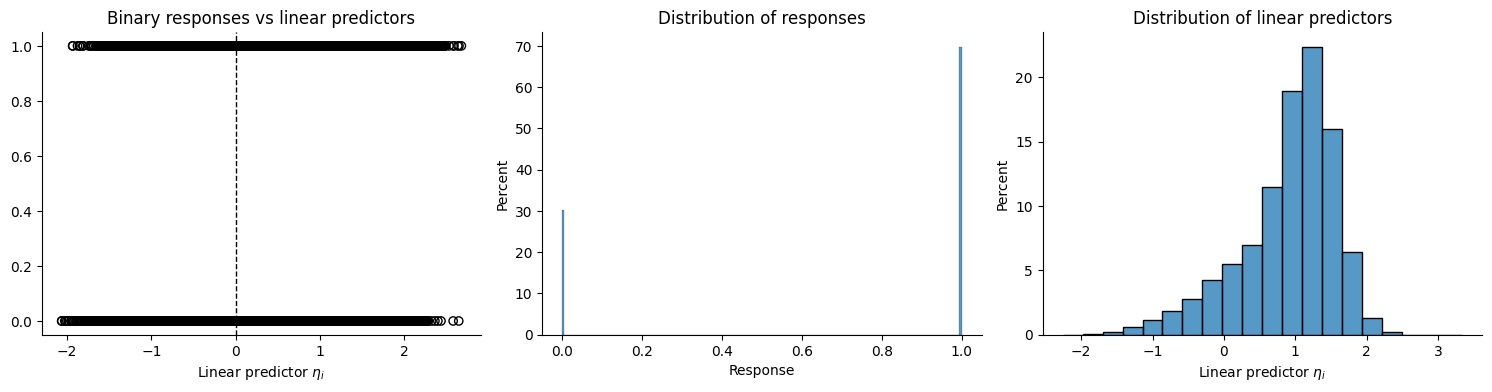

In [36]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')


plt.subplot(132)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

In [37]:
az.loo(az_fit, pointwise=True)

Computed from 4000 by 10000 log-likelihood matrix

         Estimate       SE
elpd_loo -5604.37    44.94
p_loo       32.61        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     10000  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [80]:
t = np.random.randint(0, 4000)
print(classification_report(y_test, fit["y_test"][:, t]))

              precision    recall  f1-score   support

           0       0.37      0.39      0.38       294
           1       0.74      0.72      0.73       706

    accuracy                           0.62      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.63      0.62      0.63      1000



In [126]:
with open("../stats/hs_posterior_betas.txt", "w") as f:
    print(summary_table["mean"].to_string(), file=f)

In [86]:
# Filter out parameters set to 0
summary_table[(summary_table["mean"] > 0.01) | (summary_table["mean"] <-0.01)]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.481,0.274,0.970,1.984,0.004,0.003,4176.0,2947.0,1.0
SAT,-0.320,0.029,-0.375,-0.266,0.000,0.000,4319.0,3472.0,1.0
GPA,0.097,0.027,0.046,0.148,0.000,0.000,4475.0,3141.0,1.0
income,-0.123,0.056,-0.225,-0.017,0.001,0.001,4897.0,3114.0,1.0
school_2,-0.014,0.060,-0.143,0.098,0.001,0.001,2151.0,2522.0,1.0
...,...,...,...,...,...,...,...,...,...
Black,-0.040,0.068,-0.197,0.056,0.001,0.001,2813.0,2315.0,1.0
Two or more race/ethnicity,0.040,0.064,-0.062,0.171,0.001,0.001,3053.0,2805.0,1.0
White,0.355,0.071,0.228,0.494,0.001,0.001,4779.0,3740.0,1.0
Female,0.061,0.067,-0.042,0.196,0.001,0.001,3265.0,3211.0,1.0


In [90]:
# with open("../stats/non_zero_horseshoe_prior_means.txt", "w") as f:
#     print(summary_table[(summary_table["mean"] > 0.01) | (summary_table["mean"] <-0.01)]["mean"].to_string(), file=f)

In [100]:
state2mean = dict(
    CA=-0.664,
    CO= 0.011,
    CT=-0.160,
    DC=-0.017,
    GA= 0.017,
    IA=-0.018,
    IL=-0.079,
    IN= 0.023,
    LA=-0.033,
    MA=-0.318,
    MD= 0.127,
    MI=-0.041,
    NC= 0.027,
    NH= 0.034,
    NJ= 0.088,
    NY=-0.028,
    OH= 0.043,
    OK= 0.012,
    OR= 0.045,
    PA= 0.063,
    RI=-0.078,
    SC= 0.085,
    TX= 0.272,
    VA=-0.115,
    VT= 0.013,
    WI=-0.022)

print(dict(sorted(state2mean.items(), key=lambda item: item[1])))

TypeError: 'reversed' is an invalid keyword argument for print()

{'TX': 0.272,
 'MD': 0.127,
 'NJ': 0.088,
 'SC': 0.085,
 'PA': 0.063,
 'OR': 0.045,
 'OH': 0.043,
 'NH': 0.034,
 'NC': 0.027,
 'IN': 0.023,
 'GA': 0.017,
 'VT': 0.013,
 'OK': 0.012,
 'CO': 0.011,
 'DC': -0.017,
 'IA': -0.018,
 'WI': -0.022,
 'NY': -0.028,
 'LA': -0.033,
 'MI': -0.041,
 'RI': -0.078,
 'IL': -0.079,
 'VA': -0.115,
 'CT': -0.16,
 'MA': -0.318,
 'CA': -0.664}

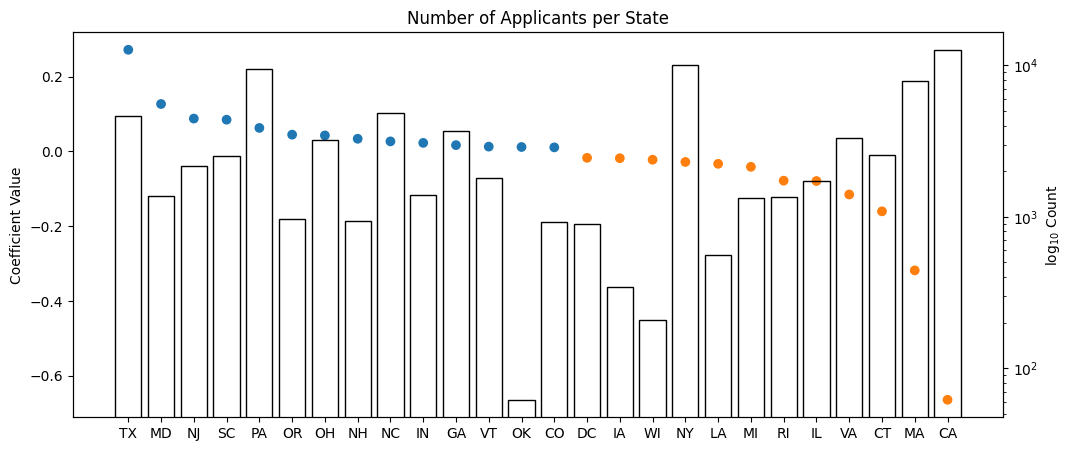

In [122]:
state2mean = {k: v for k, v in sorted(state2mean.items(), key=lambda item: item[1], reverse=True)}
state2count = dict()
# x = df['State'].value_counts().index
colors = []
for state in state2mean:
    state2count[state] = df[df["state"] == state]["state"].value_counts().values[0]
    if state2mean[state] > 0:
        colors.append("C0")
    else:
        colors.append("C1")

y = df['State'].value_counts().values

fig, ax = plt.subplots(1, 1, figsize=(12,5))
# plt.sca(ax)
ax2=ax.twinx()
ax.scatter(state2mean.keys(), state2mean.values(), c=colors)
ax.set_ylabel("Coefficient Value")
ax2.bar(state2count.keys(), state2count.values(), color=colors, log=True, fill=False)
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.title("Number of Applicants per State")
plt.ylabel("$\log_{10}$ Count")
plt.xlabel("State")
plt.show();

In [115]:
state2count

{'TX': 4639,
 'MD': 1368,
 'NJ': 2154,
 'SC': 2530,
 'PA': 9429,
 'OR': 961,
 'OH': 3211,
 'NH': 938,
 'NC': 4874,
 'IN': 1388,
 'GA': 3665,
 'VT': 1800,
 'OK': 62,
 'CO': 918,
 'DC': 903,
 'IA': 344,
 'WI': 208,
 'NY': 10115,
 'LA': 562,
 'MI': 1321,
 'RI': 1343,
 'IL': 1711,
 'VA': 3289,
 'CT': 2571,
 'MA': 7904,
 'CA': 12659}